In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
from src.module import Module
import torch 
from src.dm import DataModule
import torchmetrics
from tqdm import tqdm
import numpy as np

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
checkpoints = os.listdir('./checkpoints')
checkpoints

['fc_t456_resnest26d-val_metric=0.61026-epoch=56.ckpt',
 'fc_post_r34-val_metric=0.53231-epoch=8.ckpt',
 'fc_temp-epoch=99.ckpt',
 'all_r34-val_metric=0.54984-epoch=10.ckpt',
 'fc_t158_r34-epoch=42.ckpt',
 'fc_temp_resnest26d-epoch=22.ckpt',
 'all_r34-epoch=13.ckpt',
 'fc_temp_resnet34-val_metric=0.59515-epoch=91.ckpt',
 'fc_temp_lrsch-epoch=199.ckpt',
 'fc_pre_r34-epoch=23.ckpt',
 'fc_temp_resnest26d-val_metric=0.60265-epoch=23.ckpt',
 'fc_post_r34-epoch=13.ckpt',
 'fc_t456_resnest26d-epoch=99.ckpt',
 'fc_temp-val_metric=0.58363-epoch=89.ckpt',
 'fc_temp_resnest26d-epoch=32.ckpt',
 'fc_t158_r34-val_metric=0.57650-epoch=41.ckpt',
 'fc_pre_r34-val_metric=0.56219-epoch=21.ckpt',
 'fc_temp_resnet34-epoch=99.ckpt',
 'fc_temp_lrsch-val_metric=0.58386-epoch=67.ckpt']

In [4]:
name = "fc_t456_resnest26d-val_metric=0.61026-epoch=56.ckpt"
# name = "fc_temp_resnet34-val_metric=0.59515-epoch=91.ckpt"
checkpoint = f'./checkpoints/{name}'

In [5]:
module = Module.load_from_checkpoint(checkpoint, map_location='cpu')

In [6]:
def eval(model, device=1):
	dm = DataModule(false_color=True, t=(3,4,5))
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.Dice().cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = model(x.cuda(device))
			metric(y_hat, y.cuda(device))
			pbar.set_description(f'Dice: {metric.compute().cpu().item():.5f}')

In [7]:
eval(module)

Dice: 0.61751: 100%|██████████| 116/116 [00:16<00:00,  6.86it/s]


In [8]:
# OJO!!! esto hace que algunos modelos luego vayan mal !!!
# hacer el trace en modo train
# module.eval()

module.cpu()
module.train()

traced = torch.jit.trace(module.model, torch.rand(10, 256, 256, 3, 3))
traced.save(f'kaggle-dataset/{name[:-5]}.pt')

/home/juan/.local/lib/python3.10/site-packages/einops/einops.py:316: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  known: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] != _unknown_axis_length}
/home/juan/.local/lib/python3.10/site-packages/einops/einops.py:317: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  unknown: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] == _unknown_axis_length}


In [9]:
loaded = torch.jit.load(f'kaggle-dataset/{name[:-5]}.pt')
loaded;

In [10]:
# check traced model (debería dar parecido a antes de tracear)

eval(loaded)

Dice: 0.60151: 100%|██████████| 116/116 [00:34<00:00,  3.31it/s]


In [11]:
dm = DataModule(false_color=True, t=(3,4,5))
dm.setup()

loaded.eval()
loaded.cuda(1)

thresholds =  np.linspace(0.1, 0.9, 9)
dices, dices2 = [], []

for threshold in thresholds:
	metric = torchmetrics.Dice(threshold=threshold).cuda(1)
	metric2 = torchmetrics.Dice(threshold=threshold).cuda(1)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = loaded(x.cuda(1))
			metric(y_hat, y.cuda(1))
			#  put to zero all images with less than 10 pixels with value 1
			pr = torch.sigmoid(y_hat) > threshold
			pr = pr.long()
			for item in range(pr.shape[0]):
				if torch.sum(pr[item]) < 10:
					y_hat[item] = torch.zeros_like(pr[item])
			metric2(y_hat, y.cuda(1))
			pbar.set_description(f'Threshold: {threshold:.3f} Dice: {metric.compute().cpu().item():.5f} Dice (post): {np.mean(metric2).compute().cpu().item():.5f}')
	dices.append(metric.compute().cpu().item())
	dices2.append(metric2.compute().cpu().item())

data = pd.DataFrame({'threshold': thresholds, 'dice': dices, 'dice2': dices2})

Threshold: 0.100 Dice: 0.60157 Dice (post): 0.60183: 100%|██████████| 116/116 [00:14<00:00,  8.22it/s]
Threshold: 0.200 Dice: 0.60160 Dice (post): 0.60186: 100%|██████████| 116/116 [00:14<00:00,  8.18it/s]
Threshold: 0.300 Dice: 0.60160 Dice (post): 0.60185: 100%|██████████| 116/116 [00:14<00:00,  8.01it/s]
Threshold: 0.400 Dice: 0.60152 Dice (post): 0.60181: 100%|██████████| 116/116 [00:14<00:00,  7.95it/s]
Threshold: 0.500 Dice: 0.60151 Dice (post): 0.60179: 100%|██████████| 116/116 [00:14<00:00,  8.00it/s]
Threshold: 0.600 Dice: 0.60161 Dice (post): 0.60193: 100%|██████████| 116/116 [00:14<00:00,  7.94it/s]
Threshold: 0.700 Dice: 0.60156 Dice (post): 0.60189: 100%|██████████| 116/116 [00:14<00:00,  8.02it/s]
Threshold: 0.800 Dice: 0.60144 Dice (post): 0.60176: 100%|██████████| 116/116 [00:14<00:00,  7.94it/s]
Threshold: 0.900 Dice: 0.60146 Dice (post): 0.60182: 100%|██████████| 116/116 [00:14<00:00,  7.92it/s]


In [12]:
data

,threshold,dice,dice2
0,0.1,0.601569,0.601828
1,0.2,0.601595,0.601859
2,0.3,0.601597,0.601852
3,0.4,0.601525,0.601809
4,0.5,0.601505,0.601787
5,0.6,0.601610,0.601928
6,0.7,0.601560,0.601886
7,0.8,0.601437,0.601756
8,0.9,0.601455,0.601821


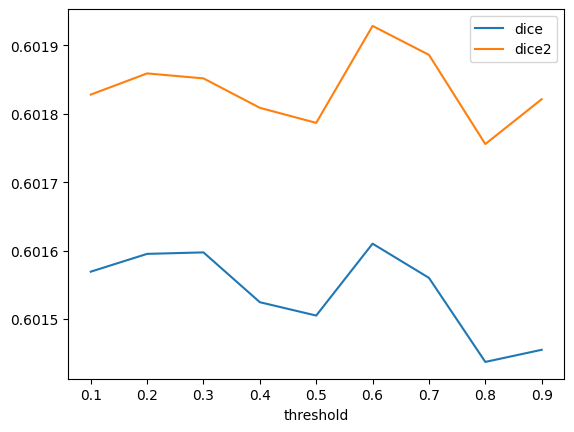

In [13]:
data.plot(x='threshold', y=['dice', 'dice2']);

In [14]:
# get threshold with max dice and dice2
data.loc[data['dice2'].idxmax()]

threshold    0.600000
dice         0.601610
dice2        0.601928
Name: 5, dtype: float64

In [15]:
path = Path('/fastdata/contrails')

records = os.listdir(path / 'test')
len(records)

2

In [16]:
stats = pd.read_csv(path/'stats.csv', index_col=0)
stats

,min,max,mean,std
8,175.82391,280.14868,233.67686,4.545741
9,180.74695,279.48690,242.25447,6.057177
10,181.44263,331.13394,250.75069,7.620164
11,179.33739,332.06036,274.41205,13.668153
12,187.69131,306.21823,255.52716,8.708825
13,179.34510,338.05670,276.60184,14.446373
14,178.71164,338.63330,275.35940,14.736154
15,178.36511,333.21048,272.56410,14.367307
16,137.39153,311.97977,260.42580,11.049050


In [17]:
import torch 
import numpy as np

def normalize_range(data, bounds):
    return (data - bounds[0]) / (bounds[1] - bounds[0])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, t=tuple(range(8)), path='/fastdata/contrails/test'):
        self.records = os.listdir(path)
        self.t = t 
        self.path = path

    def __len__(self):
        return len(self.records)
    
    def preprocess(self, record):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        b11 = np.load(f'{self.path}/{record}/band_11.npy')[..., self.t]
        b14 = np.load(f'{self.path}/{record}/band_14.npy')[..., self.t]
        b15 = np.load(f'{self.path}/{record}/band_15.npy')[..., self.t]
        r = normalize_range(b15 - b14, _TDIFF_BOUNDS)
        g = normalize_range(b14 - b11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(b14, _T11_BOUNDS)
        return np.clip(np.stack([r, g, b], axis=-1), 0, 1)
    
    def __getitem__(self, ix):
        record = self.records[ix]
        image = self.preprocess(record)
        return record, torch.from_numpy(image) # H, W, T, C

In [18]:
ds = Dataset((3,4,5))
dl = torch.utils.data.DataLoader(ds, batch_size=8, num_workers=4, pin_memory=True)

In [19]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [20]:
submission = {'record_id': [],	'encoded_pixels': []}

In [21]:
loaded.eval()
loaded.cuda(1)
with torch.no_grad():
    for records, x in dl:
        y_hat = loaded(x.cuda(1))
        masks = y_hat.sigmoid().cpu().numpy() > 0.5
        masks = masks.astype(np.int32)
        for ix in range(masks.shape[0]):
            mask = masks[ix][0] 
            if np.sum(masks[ix]) < 10:
                mask = np.zeros_like(mask)
            rle = rle_encode(mask)
            record = records[ix]
            submission['record_id'].append(record)
            if len(rle) == 0: 
                submission['encoded_pixels'].append('-')
            else:
                submission['encoded_pixels'].append(' '.join(map(str,rle)))

In [22]:
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv', index=False)
submission

,record_id,encoded_pixels
0,1002653297254493116,2284 1 2540 1 2794 2 3304 1 3814 1 4070 1 1116...
1,1000834164244036115,-


In [23]:
!kaggle datasets version -m "update" -p kaggle-dataset

Starting upload for file fc_t456_resnest26d-val_metric=0.61026-epoch=56.pt
100%|████████████████████████████████████████| 401M/401M [00:09<00:00, 42.2MB/s]
Upload successful: fc_t456_resnest26d-val_metric=0.61026-epoch=56.pt (401MB)
Starting upload for file fc_temp_resnet34-val_metric=0.58998-epoch=65.pt
100%|████████████████████████████████████████| 104M/104M [00:03<00:00, 27.2MB/s]
Upload successful: fc_temp_resnet34-val_metric=0.58998-epoch=65.pt (104MB)
Starting upload for file fc_temp_resnest26d-val_metric=0.59478-epoch=21.pt
100%|████████████████████████████████████████| 401M/401M [00:10<00:00, 39.7MB/s]
Upload successful: fc_temp_resnest26d-val_metric=0.59478-epoch=21.pt (401MB)
Starting upload for file stats.csv
100%|████████████████████████████████████████████| 392/392 [00:00<00:00, 587B/s]
Upload successful: stats.csv (392B)
Starting upload for file fc_temp_resnest26d-val_metric=0.59128-epoch=17.pt
100%|████████████████████████████████████████| 401M/401M [00:10<00:00, 41.2MB/